#Titanic Survival Prediction

In [72]:
# Clone the GitHub repository
!git clone https://github.com/geopan2000/TitanicSurvival.git

# Change directory to the cloned repository
%cd TitanicSurvival

Cloning into 'TitanicSurvival'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 18 (delta 2), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (18/18), 42.97 KiB | 10.74 MiB/s, done.
Resolving deltas: 100% (2/2), done.
/content/TitanicSurvival/TitanicSurvival/TitanicSurvival/TitanicSurvival/TitanicSurvival/TitanicSurvival/TitanicSurvival/TitanicSurvival/TitanicSurvival


In [73]:
import pandas as pd
import numpy as np
import xgboost as xgb

!pip install scikit-optimize
!pip install shap
from skopt import BayesSearchCV
from skopt.space import Real, Integer

from sklearn.model_selection import KFold
from skopt import BayesSearchCV
from skopt.space import Real, Integer

In [74]:
train_data = pd.read_csv('data/train.csv')
print(train_data.isna().sum())
print(train_data.info())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
Non

In [75]:
test_data = pd.read_csv('data/test.csv')
print(test_data.isna().sum())

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


## Data Pre-Processing

In [76]:
from sklearn.preprocessing import LabelEncoder


# Apply the mapping to both the training and test data
def map_ordinal_features(df, mappings):
    for feature, mapping in mappings.items():
        df[feature] = df[feature].map(mapping)
    return df

def frequency_encoding(train_df, test_df, column):
    # Get the frequency of each category in the train data
    freq_map = train_df[column].value_counts(normalize=True).to_dict()

    # Map the frequencies to the train and test data using the same mapping
    train_df[column] = train_df[column].map(freq_map)
    test_df[column] = test_df[column].map(freq_map)

    return train_df, test_df

def binary_encoding(df, mappings):
    for feature, mapping in mappings.items():
        df[feature] = df[feature].map(mapping)
    return df

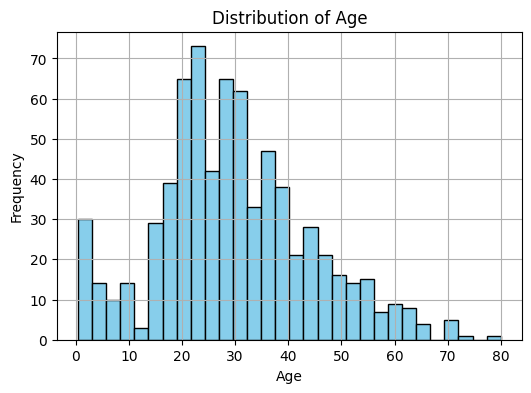

In [77]:
import matplotlib.pyplot as plt

# Plot histogram for Age
plt.figure(figsize=(6, 4))
plt.hist(train_data['Age'], bins=30, edgecolor='black', color='skyblue')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [78]:
# Transform Age to 0-1 scale
train_data['Age'].fillna(train_data['Age'].median(), inplace=True)
train_data['Age'] = train_data['Age'] / 100

test_data['Age'].fillna(train_data['Age'].median(), inplace=True)
test_data['Age'] = test_data['Age'] / 100

# Apply one-hot encoding on Embarked in train and test data
train_data = train_data.dropna(subset=['Embarked'])

train_data = pd.get_dummies(train_data, columns=['Embarked'])
test_data = pd.get_dummies(test_data, columns=['Embarked'])

# Fill missing Fare values in test data
test_data['Fare'] = test_data['Fare'].fillna(test_data['Fare'].mean())

# Cabin processing
train_data['Cabin'] = train_data['Cabin'].fillna('X000')
train_data['cabin_letter'] = train_data['Cabin'].str.extract(r'([a-zA-Z]+)', expand=False)
train_data['cabin_number'] = train_data['Cabin'].str.extract(r'(\d+)', expand=False)
train_data['cabin_number'] = train_data['cabin_number'].astype(float)
train_data['cabin_number'] = train_data['cabin_number'].fillna(0)
# Apply one-hot encoding on cabin_letter
train_data = pd.get_dummies(train_data, columns=['cabin_letter'], prefix='cabin')

# Process test data for Cabin similarly
test_data['Cabin'] = test_data['Cabin'].fillna('X000')
test_data['cabin_letter'] = test_data['Cabin'].str.extract(r'([a-zA-Z]+)', expand=False)
test_data['cabin_number'] = test_data['Cabin'].str.extract(r'(\d+)', expand=False)
test_data['cabin_number'] = test_data['cabin_number'].astype(float)
test_data['cabin_number'] = test_data['cabin_number'].fillna(0)

# Apply one-hot encoding on cabin_letter in test data
test_data = pd.get_dummies(test_data, columns=['cabin_letter'], prefix='cabin')

# Transform the 'Sex' column: 'male' to 1 and 'female' to 0
train_data['Sex'] = train_data['Sex'].map({'male': 1, 'female': 0})
test_data['Sex'] = test_data['Sex'].map({'male': 1, 'female': 0})


# Drop Name and Ticket number because they are not related
train_data.drop(['Name', 'Ticket','Cabin'], axis=1, inplace=True)
test_data.drop(['Name', 'Ticket','Cabin'], axis=1, inplace=True)

# Ensure that train and test have the same columns
train_data, test_data = train_data.align(test_data, join='left', axis=1, fill_value=0)

print(train_data.head())
print(test_data.head())


   PassengerId  Survived  Pclass  Sex   Age  SibSp  Parch     Fare  \
0            1         0       3    1  0.22      1      0   7.2500   
1            2         1       1    0  0.38      1      0  71.2833   
2            3         1       3    0  0.26      0      0   7.9250   
3            4         1       1    0  0.35      1      0  53.1000   
4            5         0       3    1  0.35      0      0   8.0500   

   Embarked_C  Embarked_Q  ...  cabin_number  cabin_A  cabin_B  cabin_C  \
0       False       False  ...           0.0    False    False    False   
1        True       False  ...          85.0    False    False     True   
2       False       False  ...           0.0    False    False    False   
3       False       False  ...         123.0    False    False     True   
4       False       False  ...           0.0    False    False    False   

   cabin_D  cabin_E  cabin_F  cabin_G  cabin_T  cabin_X  
0    False    False    False    False    False     True  
1    False  

<ipython-input-78-840a47d25525>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['Age'].fillna(train_data['Age'].median(), inplace=True)
<ipython-input-78-840a47d25525>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac

In [79]:
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   889 non-null    int64  
 1   Survived      889 non-null    int64  
 2   Pclass        889 non-null    int64  
 3   Sex           889 non-null    int64  
 4   Age           889 non-null    float64
 5   SibSp         889 non-null    int64  
 6   Parch         889 non-null    int64  
 7   Fare          889 non-null    float64
 8   Embarked_C    889 non-null    bool   
 9   Embarked_Q    889 non-null    bool   
 10  Embarked_S    889 non-null    bool   
 11  cabin_number  889 non-null    float64
 12  cabin_A       889 non-null    bool   
 13  cabin_B       889 non-null    bool   
 14  cabin_C       889 non-null    bool   
 15  cabin_D       889 non-null    bool   
 16  cabin_E       889 non-null    bool   
 17  cabin_F       889 non-null    bool   
 18  cabin_G       889 non-null    bool 

In [80]:
passenger_id_train=train_data['PassengerId']
train_data.drop('PassengerId', axis=1, inplace=True)

passenger_id_test=test_data['PassengerId']
test_data.drop('PassengerId', axis=1, inplace=True)


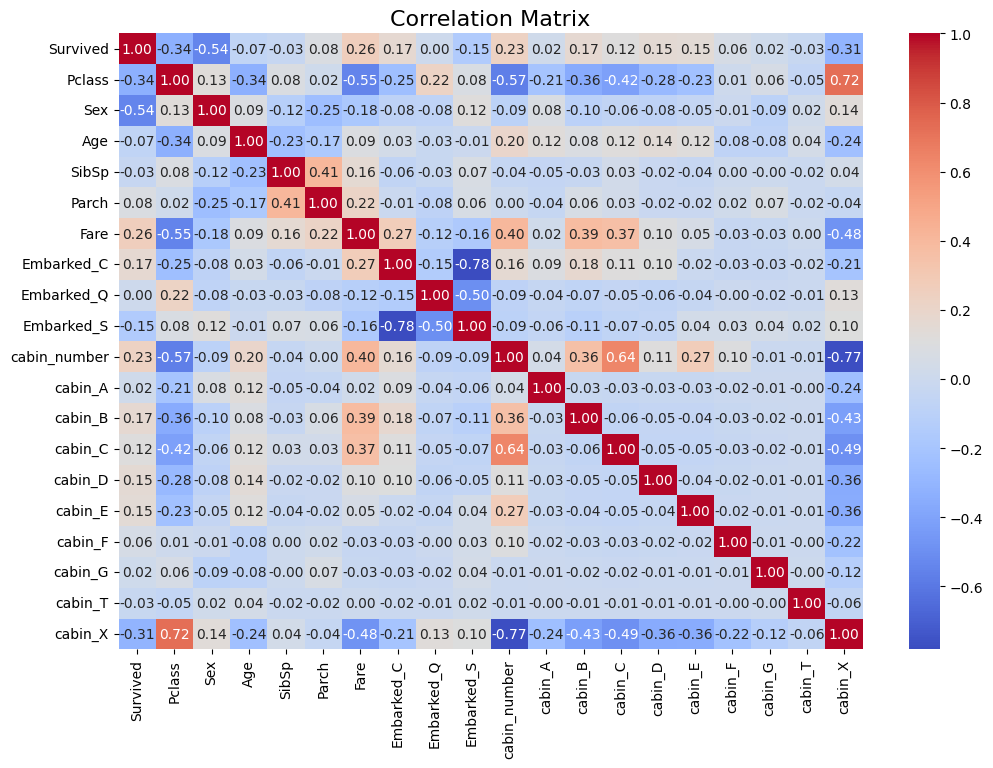

In [81]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = train_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Draw the heatmap with Seaborn
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

# Title and display the plot
plt.title('Correlation Matrix', fontsize=16)
plt.show()


In [82]:
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1  # +1 for the person themselves
train_data['IsAlone'] = (train_data['FamilySize'] == 1).astype(int)
train_data['FarePerPerson'] = train_data['Fare'] / train_data['FamilySize']
train_data['AgeClass'] = train_data['Age'] * train_data['Pclass']
train_data['CabinKnown'] = (train_data['cabin_number'].notnull()).astype(int)
train_data['AgeGroup'] = pd.cut(train_data['Age'], bins=[0, 12, 18, 60, 80], labels=['1', '2', '3', '4'])
train_data['HighFare'] = (train_data['Fare'] > train_data['Fare'].median()).astype(int)
train_data['HasRelatives'] = ((train_data['SibSp'] > 0) | (train_data['Parch'] > 0)).astype(int)
train_data['AgeSex'] = train_data['Age'] * train_data['Sex']
train_data['LogFare'] = np.log1p(train_data['Fare'])  # log(1 + Fare) to handle zero fares
train_data['RelativeAge'] = train_data['Age'] / train_data['FamilySize']
train_data['PclassFare'] = train_data['Pclass'] * train_data['Fare']
train_data['FarePerCabin'] = train_data['Fare'] / (train_data['FamilySize'])
train_data['IsVIP'] = ((train_data['Pclass'] == 1) & (train_data['Fare'] > train_data['Fare'].mean())).astype(int)
train_data['SibSpParchRatio'] = train_data['SibSp'] / (train_data['Parch'] + 1)  # Add 1 to avoid division by zero
train_data['ChildOrSenior'] = ((train_data['Age'] < 12) | (train_data['Age'] > 60)).astype(int)

test_data['FamilySize'] = test_data['SibSp'] + test_data['Parch'] + 1
test_data['IsAlone'] = (test_data['FamilySize'] == 1).astype(int)


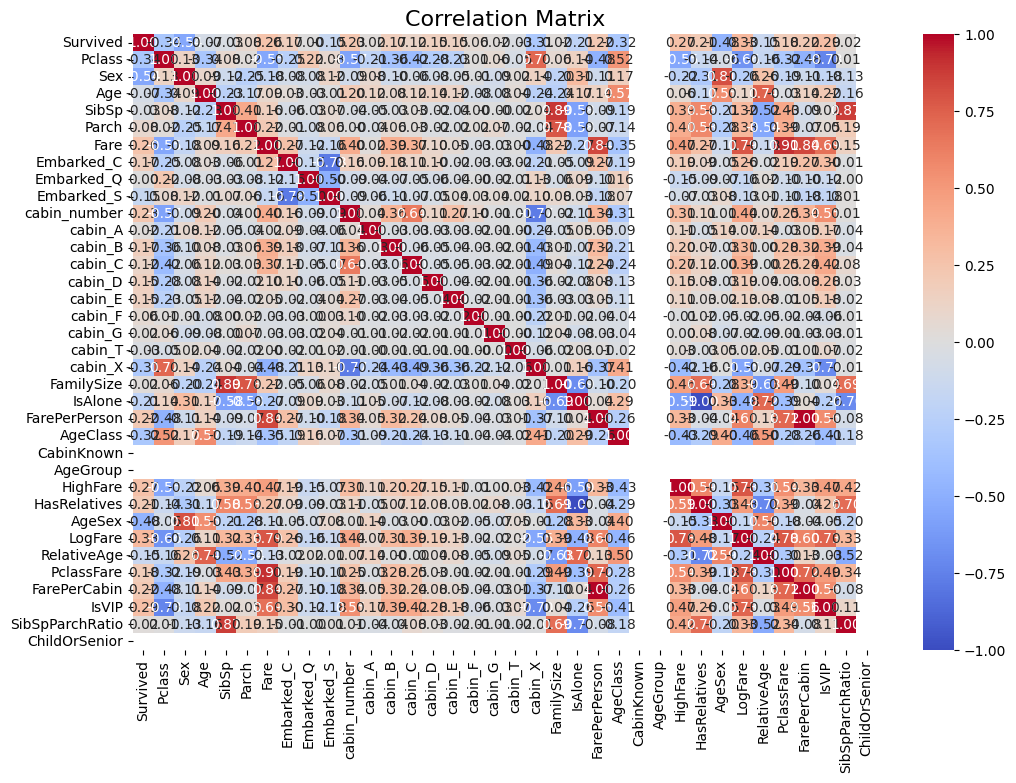

In [83]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = train_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Draw the heatmap with Seaborn
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

# Title and display the plot
plt.title('Correlation Matrix', fontsize=16)
plt.show()

In [ ]:
target_column = train_data['Survived']
train_data.drop('Survived', axis=1, inplace=True)

In [ ]:
# Check what GPU is available in Google Colab
!nvidia-smi

# Define parameter search space
search_spaces = {
    'learning_rate': Real(0.001, 0.5, 'uniform'),
    'max_depth': Integer(1, 70),
    'n_estimators': Integer(100, 800),
}

# Initialize the XGBClassifier model with GPU support
model = xgb.XGBClassifier(
    objective='binary:logistic',  # Use for binary classification
    tree_method='gpu_hist',  # Use GPU for training
    verbosity=2
)

kf = KFold(n_splits=10)  # 10-fold cross-validation

# Using 'accuracy' as the scoring metric (can be changed to roc_auc, f1, etc.)
optimizer = BayesSearchCV(
    estimator=model,
    search_spaces=search_spaces,
    n_iter=32,
    cv=kf,
    scoring='accuracy',  # Use classification accuracy as the scoring metric
    verbose=1,
    n_jobs=-1,
    return_train_score=True
)

# Fit the optimizer using X_train and y_train (classification labels, not log-transformed)
optimizer.fit(train_data, target_column)

# Get the best model
best_model = optimizer.best_estimator_

# Get cross-validation results
cv_results = optimizer.cv_results_

# Print best parameters and mean accuracy
mean_accuracy = cv_results['mean_test_score']  # Mean accuracy for each fold

print(f"Best parameters: {optimizer.best_params_}")
print(f"Mean Cross-validation Accuracy: {mean_accuracy.mean():.4f}")
print(f"Cross-validation Accuracy for each iteration: {mean_accuracy}")

print("Optimization complete. Best XGBoost classifier model saved.")


Wed Oct 23 13:08:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:23:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Best parameters: OrderedDict([('learning_rate', 0.02141371663804202), ('max_depth', 28), ('n_estimators', 110)])
Mean Cross-validation Accuracy: 0.7877
Cross-validation Accuracy for each iteration: [0.78855975 0.7862998  0.78628703 0.77846016 0.78516343 0.79642492
 0.79304137 0.77056946 0.78854699 0.77506384 0.80879724 0.82228039
 0.81778601 0.61756895 0.61756895 0.61756895 0.80203013 0.78854699
 0.82114402 0.79980848 0.7862998  0.81666241 0.81892237 0.8020429
 0.78628703 0.82000766 0.80542646 0.80430286 0.78965781 0.79530133
 0.79980848 0.79756129 0.79867211 0.79530133 0.79864658 0.81103166
 0.79304137 0.79753575 0.79643769 0.80429009 0.82005873 0.82340398
 0.80655005 0.61756895 0.82226762 0.79867211 0.79191777 0.80656282
 0.81553882 0.80094484 0.78965781 0.80091931 0.79868488 0.8020429
 0.80431563 0.79867211 0.79980848 0.78516343 0.7840526  0.79081971
 0.79193054 0.79979571 0.79306691 0.79193054]
Optimization complete. Best XGBoost classifier model saved.


In [ ]:
import pandas as pd

# Make predictions using the best model directly on test_data
preds = best_model.predict(test_data)

# Prepare the output DataFrame
output = pd.DataFrame({'PassengerId': test_data['PassengerId'], 'Survived': preds})

# Remove any duplicate rows by 'PassengerId'
output.drop_duplicates(subset='PassengerId', keep='first', inplace=True)

# Save predictions to a CSV file
output.to_csv('predictions.csv', index=False)

print("Predictions saved to predictions.csv")



Predictions saved to predictions.csv


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:33:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:33:38] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [ ]:
from google.colab import files
files.download('predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>